In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def viscosity(Tlava, Tcurrent, phi_crystal, phi_crystal_max, eta0):
    a = 0.04  #in K-1
    eta = eta0 * (1-(phi_crystal / phi_crystal_max)**-2.5) * np.exp(a * (Tlava - Tcurrent))

def yield_strength(Tlava, Tcurrent, phi_crystal):
    a = 1e-2 ## in PA
    b = 0.08 ## in K-1
    ys = (6500*phi_crystal**2.85) + a*np.exp(b*(Tlava-Tcurrent)-1)
    return ys

def basal_shear_stress(rho, g, h, theta_deg):
    return rho * g * h * np.sin(np.rad2deg(theta_deg))

def velocity_Newtonian(rho, h, eta, theta_deg, C = 3):
    ## Jeffreys equation
    ## C = 3 for a filled channel
    ## C=8 for a wide flow with a moving top
    ## C = 12 for a sheet flow
    vel = rho*g*h**2*np.sin(np.deg2rad(theta_deg)) / C / eta
    return vel

def velocity_Bingham(rho, g, h, eta, theta_deg, yield_strength):
    c1 = 4/3
    c2 = 1/3
    c3 = 4
    basal_stress = basal_shear_stress(rho, g, h, theta_deg)
    vel = rho*g*h**2*np.sin(theta_deg) / (3*eta) * (1 - c1*(yield_strength/basal_stress) + c2*(yield_strength/basal_stress)**c3)
    return vel

def levee_width(rho, g, eta, theta_deg, yield_strength, effusion_rate):
    wb = yield_strength / (2 * g * rho * np.deg2rad(theta_deg)**2)
    return wb
    
def levee_thickness(rho, g, eta, theta_deg, yield_strength, effusion_rate):
    h = yield_strength / g / rho/ np.deg2rad(theta_deg)
    return h

def channel_width(rho, g, eta, theta_deg, yield_strength, effusion_rate, wb):
    E= effusion_rate
    wc1 = (24 * E * eta / yield_strength / np.deg2rad(theta_deg)**2) ** (1/3)
    wc2 = ((24 * E * eta)**4 * g * rho / yield_strength**5 / np.deg2rad(theta_deg)**6) ** (1/11)

    
    if wc1 <= 2*wb:
        return wc1
    elif wc2 > 2*wb:
        return wc2
    else:
        print("channel width computation error")
        

def channel_thickness(rho, g, eta, theta_deg, yield_strength, effusion_rate):
    wb = levee_width(rho, g, eta, theta_deg, yield_strength, effusion_rate)
    wc = channel_width(rho, g, eta, theta_deg, yield_strength, effusion_rate, wb)
    wavg = 0.5 *(2* wb + wc)
    h = (yield_strength * wavg / g / rho) ** 0.5
    return h


def cooling_timescale(rho, h, Tstart, Tend, C, flux):
    t_cool = (rho*C*h*(Tstart-Tend)) / flux
    return t_cool

def advancement_timescale(w, h, l, E):
    E= effusion_rate
    volume = l*w*h
    t_adv = volume / E
    return t_adv  

def flow_length():
    pass

In [113]:
def radiative_flux(Tsurf, Tatm, emis_surf = 0.95):
    sigmaB = 5.670374419e-8                    ## Stefan Boltzmann constant
    q = sigmaB * emis_surf * (Tsurf**4 - Tatm**4)
    return q

def convection_flux(Tsurf, Tatm, hconv = 50):
    sigmaB = 5.670374419e-8                    ## Stefan Boltzmann constant
    q = hconv * (Tsurf - Tatm)
    return q

def conductive_flux():
    pass

def flynn_flux(Tsurface):
    q = 1.07e-13 * Tsurface**4.84 * 1e3
    return q

def coupled_flux(Tsurf, Tatm, k, emis_surf = 0.95):
    
    ## using formula from Siegel and Howell chapter 7
    ## 2 solutions are presented; the additive solution (eq 7-20) is used
    
    g = 8.87
    sigmaB = 5.670374419e-8                    ## Stefan Boltzmann constant
    
    k_air = 5.5e-2                             ## thermal conductivity of atmosphere Wm-1K-1 (Snyder, 2002)
    C_air = 1.15e3                             ## specific heat capacity of atmosphere Jkg-1K-1 (Snyder, 2002)
    rho_air = 65                               ## density of the atmosphere in kgm-3 (Snyder, 2002)
    eta_air = 3.4e-5                           ## dynamic viscosity of the atmosphere in kgm-3 (Snyder, 2002)
    beta_air = 1.3e-3                          ## thermal expansion coefficient (Snyder, 2002)
    kappa_air =  k_air / rho_air / C_air       ## thermal diffusivity of the atmosphere
    emis_air = 1                               ## emissivity of the atmosphere (Snyder, 2002)
    # emis_surf = 1                              ## emissivity of the surface (Snyder, 2002)
    
    H = 1                                   ## from Kesthelyi and Denlinger, 1995
    a = 0.1                                    ## gray absorption coefficient in m-1 (check if right)
    
    N = k*a / 4 / sigmaB / Tsurf**3             ## conduction parameter
    print("conduction parameter", N)
    
    # Ra_crit = 2040 * 7100 / 2.3e-4           ## Snyder (2002) use N = 2.3e-4
    Ra_crit = 2040 * 7100 / N
    Ra = g * beta_air * (Tsurf - Tatm) * H**3 / eta_air / kappa_air
    D = (Ra_crit / Ra)**(1/3)
    print("boundary layer thickness = ", D)
    
    qcond = a * (Tsurf-Tatm) / D
    qrad = sigmaB*(Tsurf**4-Tatm**4) / (0.74*D*a + emis_air**-1 + emis_surf**-1 - 1)
    qtotal = qrad + qcond
    return qtotal

In [103]:
## Initial lava conditions ##

## environemnt
g = 8.87
theta_deg = 2
Tatm = 737

## eruption
effusion_rate = 500          ## m3/s
Tlava = 1400                 ## K
rho = 2600                   ## Basalt density from Davies et al., 2006
phi0_crystal = 0.25
eta0 = 1000                  ## Pas
ys0 = 6500*phi0_crystal**2.85


## Other variables
L = 100e3                    ## latent heat capacity in J/kg; value from Wittmann et al.2017
C =  1200                    ## specific heat capacity in J/kg/K; value from Wittman et al. 2017
k = 1                        ## thermal conductivity in W/m/K from Head and Wilson 1986, and Davies et al., 2005
kappa = k/rho/C              ## thermal diffusivity in m2/s;

In [104]:
Tsurf = Tlava
eta = eta0
ys = ys0
phi_crystal = phi0_crystal


## Emplacement
wb = levee_width(rho, g, eta, theta_deg, ys, effusion_rate)
wc = channel_width(rho, g, eta, theta_deg, ys, effusion_rate, wb)
h = channel_thickness(rho, g, eta, theta_deg, ys, effusion_rate)
hb = levee_thickness(rho, g, eta, theta_deg, ys, effusion_rate)
vel = velocity_Bingham(rho, g, h, eta, theta_deg, ys)

## surface flux
qflynn = flynn_flux(Tsurf)
qcoupled = coupled_flux(Tsurf, 750, k, 0.95)  

conduction parameter 0.0001606734670198092
boundary layer thickness =  0.6700874394187851


conduction parameter [0.00013063 0.00014462 0.00016067 0.0001792  0.00020068 0.00022573
 0.00025514 0.00028989 0.00033125 0.00038086]
boundary layer thickness =  [0.68059848 0.67294471 0.66567884 0.65890303 0.65275236 0.64740908
 0.64312512 0.64025904 0.63933975 0.64118361]


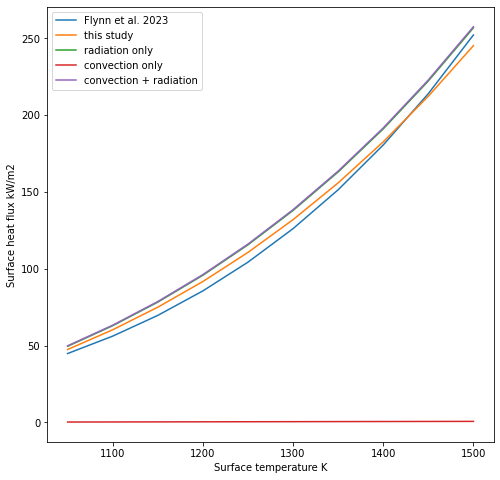

In [120]:
## comparing coupled heat loss implementations
X = np.arange(1500, 1000, -50)
flynn_2023 = flynn_flux(X) / 1e3
this_study =  coupled_flux(X, 737, k, 0.95) / 1e3
rad = radiative_flux(X, 737, 0.95) / 1e3
conv = convection_flux(X, 737, 0.95) / 1e3
plt.figure(figsize = (8,8))
plt.plot(X, flynn_2023, label = "Flynn et al. 2023")
plt.plot(X, this_study, label = "this study")
plt.plot(X, rad, label = "radiation only")
plt.plot(X, conv, label = "convection only")
plt.plot(X, conv+rad, label = "convection + radiation")
plt.xlabel("Surface temperature K")
plt.ylabel("Surface heat flux kW/m2")
plt.legend()
plt.show()

In [107]:
## calculation of new variables
eta = viscosity(Tlava, Tcurrent, phi_crystal, phi_crystal_max, eta0)
ys = yield_strength()
vel = velocity_Bingham(rho, g, h, eta, theta_deg, yield_strength)

NameError: name 'Tcurrent' is not defined